<a href="https://colab.research.google.com/github/pjjongho/Colab_AD/blob/main/Telecom%20Customer%20Churn%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 20**  
**┗ 통신사 유저 이탈 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「데이터 전처리 및 EDA」
* 🥈Session 2 - 「가설 수립 및 검증, 인사이트 발굴」
* 🥇Session 3 - 「이상 탐지 모델링」

# Prerequisites

$ pip install missingno, association-metrics

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
import os
warnings.filterwarnings('ignore') # ▶ Warnings 제거

notebook_path = '/content/drive/MyDrive/'
os.chdir(notebook_path)

# **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🧑💗 (이커머스 개발자/데이터분석가)
```
A 통신사는 고객의 과거 이용 실적에 따라 내부적으로 고객의 등급을 분류하고 있다.
이러한 고객들이 서비스를 떠나지 않도록 모니터링/관리하여 매출을 유지하려고 하고 있으며
고객의 이탈률을 예측하여 이탈이 예상되는 고객에게 새로운 오퍼를 제공하여 고객을 유지하려고 한다
```

> **데이터 살펴보기**

- 데이터로더 작성

In [71]:
from typing import Union
from pathlib import Path
import pandas as pd

class DataLoader:
    def __init__(self, data_path:Union[str, Path]):
        self.data_path = data_path
    def load_data(self) -> pd.DataFrame:
        return (
            pd.read_csv(self.data_path/'data.csv', index_col=0)
        )

data_path = Path().cwd()
data_loader = DataLoader(data_path=data_path)

In [4]:
data = data_loader.load_data()

- Customer churn 이해

![](figures/19_4.png)

![](figures/19_1.png)

* User data (고객 데이터)
* 이탈 위험을 점수로 환산하여 `Churn` 컬럼으로 보유중
* 통신사 데이터의 경우 계약을 연장하지 않으면 Churn으로 정의할 수 있음
* 데이터 명세 ⬇

In [5]:
data_description_dict = {
  'customerID': '고객 고유번호',
  'gender': '성별',
  'SeniorCitizen': '고령자 여부',
  'Partner': '기혼 여부',
  'Dependents': '부양 가족 여부',
  'tenure': '총 가입 기간',
  'PhoneService': '집전화 서비스 가입 여부',
  'MultipleLines': '가족요금제 가입 여부',
  'InternetService': '인터넷 이용 방식',
  'OnlineSecurity': '온라인 보안 가입 여부',
  'OnlineBackup': '온라인 백업 서비스 가입 여부',
  'DeviceProtection': '기기 보험 가입 여부',
  'TechSupport': '기술지원',
  'StreamingTV': 'TV 스트리밍 여부',
  'StreamingMovies': '영화 스트리밍 여부',
  'Contract': '약정 기간',
  'PaperlessBilling': '전자고지서',
  'PaymentMethod': '결제수단',
  'MonthlyCharges': '월 청구액',
  'TotalCharges': '전체기간 청구액',
  'Churn': '이탈 여부'
}

(
    pd.concat(
        [data, pd.DataFrame([data_description_dict])],
        ignore_index=True
    )
    .iloc[[-1, 0]]
    .T
    .rename(columns={7043:'데이터 설명', 0:'샘플 데이터'})
)

,데이터 설명,샘플 데이터
gender,성별,Female
SeniorCitizen,고령자 여부,0
Partner,기혼 여부,Yes
Dependents,부양 가족 여부,No
tenure,총 가입 기간,1
PhoneService,집전화 서비스 가입 여부,No
MultipleLines,가족요금제 가입 여부,No phone service
InternetService,인터넷 이용 방식,DSL
OnlineSecurity,온라인 보안 가입 여부,No
OnlineBackup,온라인 백업 서비스 가입 여부,Yes



# **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 이탈 예측 유저를 조기에 감지하여 프로모션 등 마케팅을 통해 이탈 방지
```  

> **기대효과**

```
▶ 유저 이탈률 감소
```

> **해결방안**

```
▶ 과거 유저 데이터를 바탕으로 유저 이탈 예측 모델을 개발
▶ Session 1 🥉
 - Data 전처리 및 EDA
▶ Session 2 🥈
 - 가설 수립 및 검증, 인사이트 발굴
▶ Session 3 🥇
 - 이상 탐지 모델링
```

> **성과측정**  

```
▶ 디플로이 이후 기간동안 이탈 방지율을 모니터링하여 성능 측정
```

> **현업적용**  

```
▶ Model에 Input하기 위한 Data mart 생성
▶ 예측 모델 활용을 위한 사고 데이터 수집
```



# **🥉Session 1**  
**┗ 데이터 전처리 및 EDA**  
---

### · Data 이해
---
* 수집된 데이터의 기본 정보들을 확인  

#### (1) Data shape(형태) 확인
- 얼마나 많은 Record(row)가 있는지, 사용할 수 있는 Feature(column)의 수가 얼마나 되는지 확인



In [6]:
data.shape

(7043, 20)

#### (2) Data type 확인
- Categorical, numerical feature가 얼마나 있는지 확인

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

#### (3) Null값 확인 (※ 빈 값의 Data)
- 빈 값이 있을 경우 모델에서 Null값을 핸들링해주는지 확인
- 또는 Imputation을 통해 빈 값을 채워주거나
- Imputation이 어려울 경우 해당 Row를 제거하는 방법도 고려하여야 함

In [8]:
data.isna()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5575-GNVDE,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3668-QPYBK,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7795-CFOCW,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9237-HQITU,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2234-XADUH,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4801-JZAZL,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Text(0.5, 1.0, 'User data')

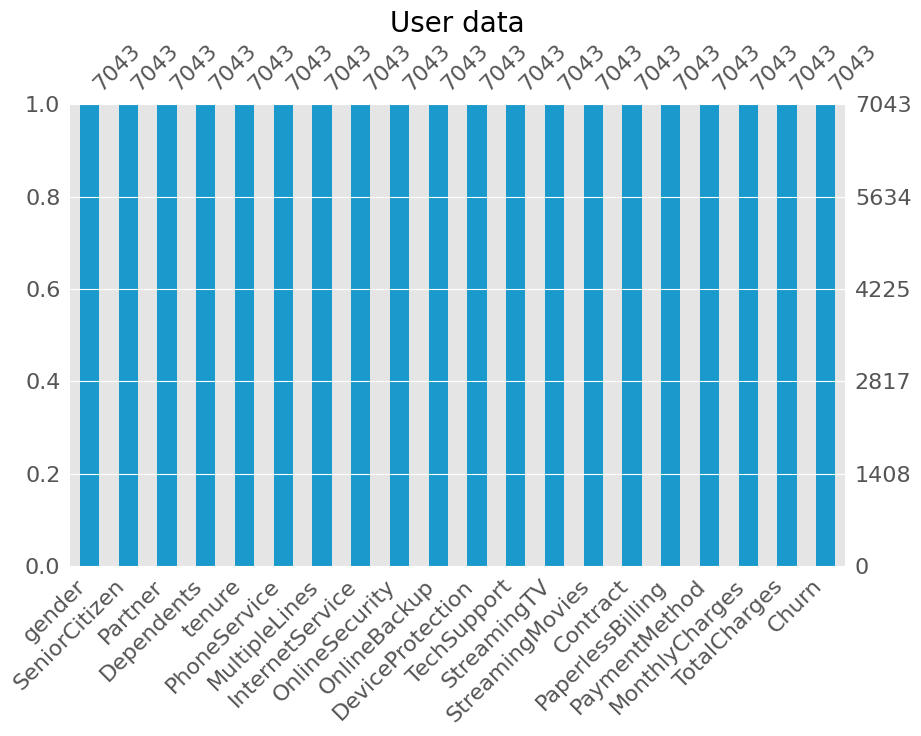

In [9]:
import matplotlib.pyplot as plt
import missingno as msno
plt.style.use('ggplot')

msno.bar(df=data, color=(0.1, 0.6, 0.8), figsize=(10, 6))
plt.title('User data', fontsize=20)

Text(0.5, 1.0, 'User data')

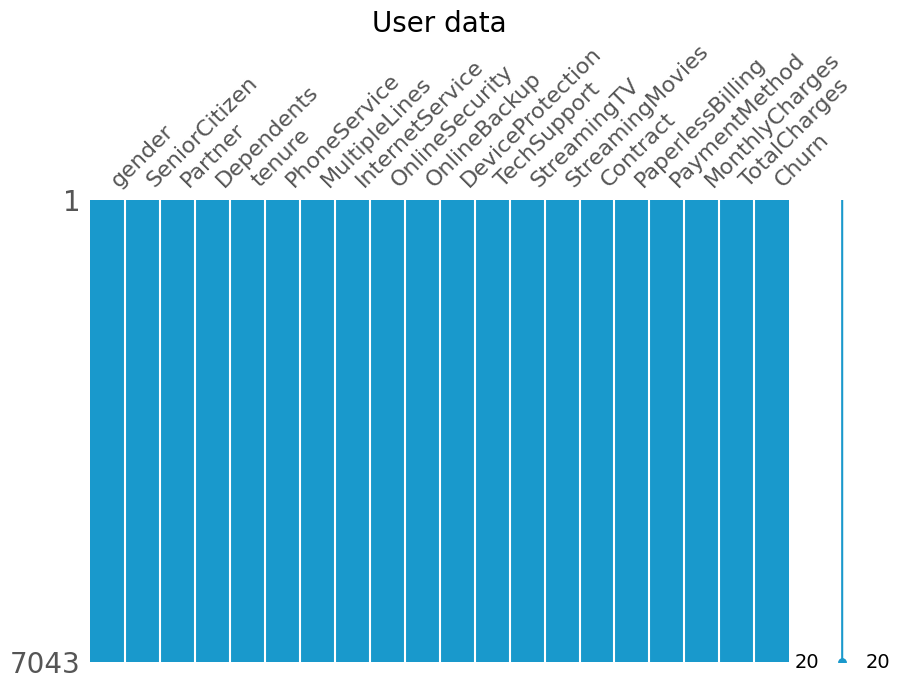

In [10]:
msno.matrix(df=data, color=(0.1, 0.6, 0.8), figsize=(10, 6))
plt.title('User data', fontsize=20)

#### (4) # of unique values, data distribution, outlier 확인 (※ 정상적인 범주를 벗어난 Data)

- number of unique values : 예측에 사용할 수 있는 유의미한 정보를 담은 Column인지, 단순 ID 등의 의미없는 Column인지 확인
- Distribution : 학습에 방해가 될 수 있는 불균형한 데이터셋인지 확인. Label이 Imbalanced한 경우 Novelty dectection 등의 모델을 고려하여야 함
- Outlier 확인 : 모델 학습에 방해가 될 수 있는 Outlier 등이 존재하는지 확인


In [11]:
(
    data
    .nunique()
    .to_frame()
    .reset_index(drop=False)
    .rename(columns={'index':'column_name', 0:'number_of_unique_values'})
)

,column_name,number_of_unique_values
0,gender,2
1,SeniorCitizen,2
2,Partner,2
3,Dependents,2
4,tenure,73
5,PhoneService,2
6,MultipleLines,3
7,InternetService,3
8,OnlineSecurity,3
9,OnlineBackup,3


Text(0, 0.5, 'Churn risk score')

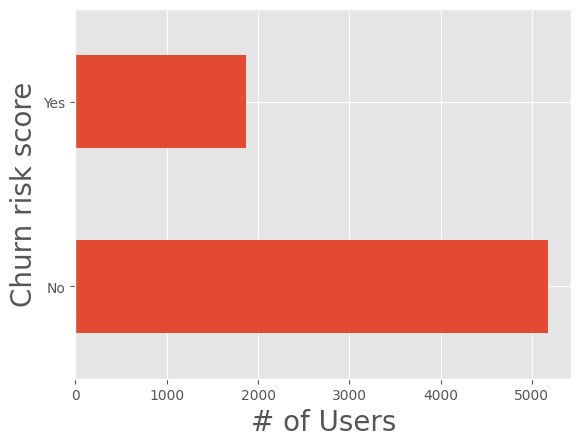

In [12]:
(
    data['Churn']
    .value_counts()
    .plot(kind='barh')
)
plt.xlabel('# of Users', fontsize=20)
plt.ylabel('Churn risk score', fontsize=20)

### · EDA로부터 얻은 인사이트
---
#### (1) 결측치 존재하지 않는 데이터
#### (2) Churn score가 binary(0,1)이기 때문에 Regression, Classification 모두 고려해볼 수 있음

# **🥈Session 2**  
**┗ 가설 수립 및 검증, 인사이트 발굴**  
---

### · 가설 수립
- EDA : 데이터를 보고 떠올리거나
- 문헌조사 : 관련 논문, 업계 리포트, 뉴스 등을 참조하거나
- 인터뷰 : 관련 부서 담당자분들께 아이디어를 얻음
---
#### (1) Demographic 간에 Churn risk에 차이가 있는지?
#### (2) 가입 기간, 약정 기간, 요금제에 따라 Churn risk에 차이가 있는지?
#### (3) 결제 금액, 결제 방식에 따라 Churn risk에 차이가 있는지?

### · 가설 검증 및 인사이트 발굴
---

#### (1) Demographic 간에 Churn risk에 차이가 있는지?

In [13]:
import plotly.express as px

demographic_features = [
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents'
]

for column in demographic_features :
    data_toplot = (
        data
        .groupby([column, 'Churn'])
        .size()
        .to_frame(name='Count')  # Count 열을 추가하여 프레임으로 변환
        .reset_index(drop=False)
        .assign(Churn=lambda x : x['Churn'].astype(str))
        .sort_values(by=['Count', column])
    )

    if data_toplot[column].nunique() < 10 :
        fig = px.bar(data_toplot, x=column, y='Count', color='Churn', barmode='group')
    else :
        fig = px.bar(data_toplot, x='Count', y=column, color='Churn', barmode='group', orientation='h')
    fig.update_layout(
        title=dict(
            text=f'{column} 별 Churn 분포',
            font=dict(size=25),
        ),
        xaxis_title=dict(
            text=column,
            font=dict(size=25),
        ),
        yaxis_title=dict(
            text="Count",
            font=dict(size=25),
        ),
    )
    fig.show()
    display(data_toplot.sort_values(by=[column, 'Churn'], ascending=False))


,gender,Churn,Count
3,Male,Yes,930
2,Male,No,2625
1,Female,Yes,939
0,Female,No,2549


,SeniorCitizen,Churn,Count
3,1,Yes,476
2,1,No,666
1,0,Yes,1393
0,0,No,4508


,Partner,Churn,Count
3,Yes,Yes,669
2,Yes,No,2733
1,No,Yes,1200
0,No,No,2441


,Dependents,Churn,Count
3,Yes,Yes,326
2,Yes,No,1784
1,No,Yes,1543
0,No,No,3390


> ##### a) Senior인 경우, 부양가족이 있는 경우 상대적으로 이탈률이 낮은 것을 확인할수 있음
> ##### b) 그 외 Demographic group간 churn rate에 어느정도 차이는 있으나, 극단적으로 큰 차이가 나는 그룹은 발견되지 않음

#### (2) 가입 기간, 약정 기간, 요금제에 따라 Churn risk에 차이가 있는지?

In [14]:
categorical_features = [
    'PhoneService',
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract'
]

for column in categorical_features :
    data_toplot = (
        data
        .groupby([column, 'Churn'])
        .size()
        .to_frame(name='Count')  #
        .reset_index(drop=False)
        .assign(Churn=lambda x : x['Churn'].astype(str))
        .sort_values(by=['Count', column])
    )

    if data_toplot[column].nunique() < 10 :
        fig = px.bar(data_toplot, x=column, y='Count', color='Churn', barmode='group')
    else :
        fig = px.bar(data_toplot, x='Count', y=column, color='Churn', barmode='group', orientation='h')
    fig.update_layout(
        title=dict(
            text=f'{column} 별 Churn 분포',
            font=dict(size=25),
        ),
        xaxis_title=dict(
            text=column,
            font=dict(size=25),
        ),
        yaxis_title=dict(
            text="Count",
            font=dict(size=25),
        ),
    )
    fig.show()
    display(data_toplot.sort_values(by=[column, 'Churn'], ascending=False))


,PhoneService,Churn,Count
3,Yes,Yes,1699
2,Yes,No,4662
1,No,Yes,170
0,No,No,512


,MultipleLines,Churn,Count
5,Yes,Yes,850
4,Yes,No,2121
3,No phone service,Yes,170
2,No phone service,No,512
1,No,Yes,849
0,No,No,2541


,InternetService,Churn,Count
5,No,Yes,113
4,No,No,1413
3,Fiber optic,Yes,1297
2,Fiber optic,No,1799
1,DSL,Yes,459
0,DSL,No,1962


,OnlineSecurity,Churn,Count
5,Yes,Yes,295
4,Yes,No,1724
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,1461
0,No,No,2037


,OnlineBackup,Churn,Count
5,Yes,Yes,523
4,Yes,No,1906
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,1233
0,No,No,1855


,DeviceProtection,Churn,Count
5,Yes,Yes,545
4,Yes,No,1877
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,1211
0,No,No,1884


,TechSupport,Churn,Count
5,Yes,Yes,310
4,Yes,No,1734
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,1446
0,No,No,2027


,StreamingTV,Churn,Count
5,Yes,Yes,814
4,Yes,No,1893
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,942
0,No,No,1868


,StreamingMovies,Churn,Count
5,Yes,Yes,818
4,Yes,No,1914
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,938
0,No,No,1847


,Contract,Churn,Count
5,Two year,Yes,48
4,Two year,No,1647
3,One year,Yes,166
2,One year,No,1307
1,Month-to-month,Yes,1655
0,Month-to-month,No,2220


In [15]:
import plotly.figure_factory as ff

numerical_features = [
    'tenure',
]


for column in numerical_features :

    data_toplot = [
        (
            data
            .loc[lambda x : x['Churn']=='Yes', column]
            .astype(float)
            .tolist()
        ),
        (
            data
            .loc[lambda x : x['Churn']=='No', column]
            .astype(float)
            .tolist()
        ),
    ]

    group_labels = ['Churn', 'Normal']

    fig = ff.create_distplot(data_toplot, group_labels, bin_size=1)
    fig.update_layout(
        title=dict(
            text='변수 값별 Churn 분포',
            font=dict(size=25),
        ),
        xaxis_title=dict(
            text=column,
            font=dict(size=25),
        ),
        yaxis_title=dict(
            text="P",
            font=dict(size=25),
        ),
    )
    fig.show()

> ##### a) 인터넷 서비스 형태에 따라 Churn rate에 영향을 주는 것을 알 수 있음
> ##### b) 약정 가입시 중도 이탈률이 낮음
> ##### c) 가입 기간과 이탈률은 반비례

#### (3) 결제 금액, 결제 방식에 따라 Churn risk에 차이가 있는지?

In [16]:
categorical_features = [
    'PaperlessBilling',
    'PaymentMethod',
]

for column in categorical_features :
    data_toplot = (
        data
        .groupby([column, 'Churn'])
        .size()
        .to_frame(name='Count')
        .reset_index(drop=False)
        .assign(Churn=lambda x : x['Churn'].astype(str))
        .sort_values(by=['Count', column])
    )

    if data_toplot[column].nunique() < 10 :
        fig = px.bar(data_toplot, x=column, y='Count', color='Churn', barmode='group')
    else :
        fig = px.bar(data_toplot, x='Count', y=column, color='Churn', barmode='group', orientation='h')
    fig.update_layout(
        title=dict(
            text=f'{column} 별 Churn 분포',
            font=dict(size=25),
        ),
        xaxis_title=dict(
            text=column,
            font=dict(size=25),
        ),
        yaxis_title=dict(
            text="Count",
            font=dict(size=25),
        ),
    )
    fig.show()
    display(data_toplot.sort_values(by=[column, 'Churn'], ascending=False))

,PaperlessBilling,Churn,Count
3,Yes,Yes,1400
2,Yes,No,2771
1,No,Yes,469
0,No,No,2403


,PaymentMethod,Churn,Count
7,Mailed check,Yes,308
6,Mailed check,No,1304
5,Electronic check,Yes,1071
4,Electronic check,No,1294
3,Credit card (automatic),Yes,232
2,Credit card (automatic),No,1290
1,Bank transfer (automatic),Yes,258
0,Bank transfer (automatic),No,1286


In [17]:
numerical_features = [
    'MonthlyCharges',
    'TotalCharges'
]


for column in numerical_features :

    data_toplot = [
        (
            data
            .loc[lambda x : x[column]!=' ']
            .loc[lambda x : x['Churn']=='Yes', column]
            .astype(float)
            .tolist()
        ),
        (
            data
            .loc[lambda x : x[column]!=' ']
            .loc[lambda x : x['Churn']=='No', column]
            .astype(float)
            .tolist()
        ),
    ]

    group_labels = ['Churn', 'Normal']

    fig = ff.create_distplot(data_toplot, group_labels, bin_size=1)
    fig.update_layout(
        title=dict(
            text='변수 값별 Churn 분포',
            font=dict(size=25),
        ),
        xaxis_title=dict(
            text=column,
            font=dict(size=25),
        ),
        yaxis_title=dict(
            text="P",
            font=dict(size=25),
        ),
    )
    fig.show()

> ##### a) 월별 이용 금액이 높은 이용자의 경우에 이탈률이 높음
> ##### b) 총금액과 이용기간이 비례한다는 점을 고려했을때, 마찬가지로 오래 사용했을 경우에 이탈률이 낮은 것을 알 수 있음

### · 중요변수 탐색
---

In [18]:
data.iloc[:2].T

customerID,7590-VHVEG,5575-GNVDE
gender,Female,Male
SeniorCitizen,0,0
Partner,Yes,No
Dependents,No,No
tenure,1,34
PhoneService,No,Yes
MultipleLines,No phone service,No
InternetService,DSL,DSL
OnlineSecurity,No,Yes
OnlineBackup,Yes,No


In [19]:
data = (
    data
    .assign(TotalCharges=lambda x : x['TotalCharges'].apply(lambda y : 0 if y==' ' else y))
)

In [20]:
(
    pd.DataFrame(
        [(column, data[column].unique().shape[0], data[column].dtype) for column in data.columns],
        columns=['column_name', 'number_of_unique_values', 'dtype']
    )
    .sort_values(by='number_of_unique_values')
    .assign(data_shape=data.shape[0])
)

,column_name,number_of_unique_values,dtype,data_shape
0,gender,2,object,7043
15,PaperlessBilling,2,object,7043
5,PhoneService,2,object,7043
19,Churn,2,object,7043
2,Partner,2,object,7043
1,SeniorCitizen,2,int64,7043
3,Dependents,2,object,7043
6,MultipleLines,3,object,7043
7,InternetService,3,object,7043
8,OnlineSecurity,3,object,7043


In [21]:
features_to_investigate = data.columns.tolist()
features_to_investigate.remove('Churn')
features_to_investigate

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

#### (1) Categorical values

##### a) Distribution check

In [22]:
data.iloc[:2].T

customerID,7590-VHVEG,5575-GNVDE
gender,Female,Male
SeniorCitizen,0,0
Partner,Yes,No
Dependents,No,No
tenure,1,34
PhoneService,No,Yes
MultipleLines,No phone service,No
InternetService,DSL,DSL
OnlineSecurity,No,Yes
OnlineBackup,Yes,No


In [23]:
(
    data
    .loc[:, features_to_investigate]
    .select_dtypes('object')
    .iloc[:2]
    .T
)

customerID,7590-VHVEG,5575-GNVDE
gender,Female,Male
Partner,Yes,No
Dependents,No,No
PhoneService,No,Yes
MultipleLines,No phone service,No
InternetService,DSL,DSL
OnlineSecurity,No,Yes
OnlineBackup,Yes,No
DeviceProtection,No,Yes
TechSupport,No,No


In [24]:
data['TotalCharges'].value_counts()

,TotalCharges
0,11
20.2,11
19.75,9
20.05,8
19.9,8
...,...
6849.4,1
692.35,1
130.15,1
3211.9,1


In [25]:
data['TotalCharges'] = data['TotalCharges'].astype(float)

In [26]:
(
    data
    .loc[:, features_to_investigate]
    .select_dtypes('object')
    .iloc[:2]
    .T
)

customerID,7590-VHVEG,5575-GNVDE
gender,Female,Male
Partner,Yes,No
Dependents,No,No
PhoneService,No,Yes
MultipleLines,No phone service,No
InternetService,DSL,DSL
OnlineSecurity,No,Yes
OnlineBackup,Yes,No
DeviceProtection,No,Yes
TechSupport,No,No


In [27]:
categorical_features_to_investigate = (
    data
    .loc[:, features_to_investigate]
    .select_dtypes('object')
    .columns
    .tolist()
)
categorical_features_to_investigate

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [28]:
for column in categorical_features_to_investigate :
    data_toplot = (
        data
        .groupby([column, 'Churn'])
        .size()
        .to_frame(name='Count')
        .reset_index(drop=False)
        .sort_values(by='Churn')
    )
    data_toplot[column] = data_toplot[column].astype(str)
    data_toplot['Churn'] = data_toplot['Churn'].astype(str)

    if data_toplot[column].nunique() < 10 :
        fig = px.bar(data_toplot, x=column, y='Count', color='Churn', barmode='group')
    else :
        fig = px.bar(data_toplot, x='Count', y=column, color='Churn', barmode='group', orientation='h')
    fig.update_layout(
        title=dict(
            text='변수 값별 Churn 분포',
            font=dict(size=25),
        ),
        xaxis_title=dict(
            text=column,
            font=dict(size=25),
        ),
        yaxis_title=dict(
            text="Count",
            font=dict(size=25),
        ),
    )
    fig.show()
    display(data_toplot.sort_values(by=[column, 'Churn'], ascending=False))


,gender,Churn,Count
3,Male,Yes,930
2,Male,No,2625
1,Female,Yes,939
0,Female,No,2549


,Partner,Churn,Count
3,Yes,Yes,669
2,Yes,No,2733
1,No,Yes,1200
0,No,No,2441


,Dependents,Churn,Count
3,Yes,Yes,326
2,Yes,No,1784
1,No,Yes,1543
0,No,No,3390


,PhoneService,Churn,Count
3,Yes,Yes,1699
2,Yes,No,4662
1,No,Yes,170
0,No,No,512


,MultipleLines,Churn,Count
5,Yes,Yes,850
4,Yes,No,2121
3,No phone service,Yes,170
2,No phone service,No,512
1,No,Yes,849
0,No,No,2541


,InternetService,Churn,Count
5,No,Yes,113
4,No,No,1413
3,Fiber optic,Yes,1297
2,Fiber optic,No,1799
1,DSL,Yes,459
0,DSL,No,1962


,OnlineSecurity,Churn,Count
5,Yes,Yes,295
4,Yes,No,1724
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,1461
0,No,No,2037


,OnlineBackup,Churn,Count
5,Yes,Yes,523
4,Yes,No,1906
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,1233
0,No,No,1855


,DeviceProtection,Churn,Count
5,Yes,Yes,545
4,Yes,No,1877
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,1211
0,No,No,1884


,TechSupport,Churn,Count
5,Yes,Yes,310
4,Yes,No,1734
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,1446
0,No,No,2027


,StreamingTV,Churn,Count
5,Yes,Yes,814
4,Yes,No,1893
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,942
0,No,No,1868


,StreamingMovies,Churn,Count
5,Yes,Yes,818
4,Yes,No,1914
3,No internet service,Yes,113
2,No internet service,No,1413
1,No,Yes,938
0,No,No,1847


,Contract,Churn,Count
5,Two year,Yes,48
4,Two year,No,1647
3,One year,Yes,166
2,One year,No,1307
1,Month-to-month,Yes,1655
0,Month-to-month,No,2220


,PaperlessBilling,Churn,Count
3,Yes,Yes,1400
2,Yes,No,2771
1,No,Yes,469
0,No,No,2403


,PaymentMethod,Churn,Count
7,Mailed check,Yes,308
6,Mailed check,No,1304
5,Electronic check,Yes,1071
4,Electronic check,No,1294
3,Credit card (automatic),Yes,232
2,Credit card (automatic),No,1290
1,Bank transfer (automatic),Yes,258
0,Bank transfer (automatic),No,1286


#### (1) Numerical values
##### a) Correlation

In [29]:
(
    data
    .loc[:, features_to_investigate]
    .select_dtypes('number')
)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
customerID,,,,
7590-VHVEG,0,1,29.85,29.85
5575-GNVDE,0,34,56.95,1889.50
3668-QPYBK,0,2,53.85,108.15
7795-CFOCW,0,45,42.30,1840.75
9237-HQITU,0,2,70.70,151.65
...,...,...,...,...
6840-RESVB,0,24,84.80,1990.50
2234-XADUH,0,72,103.20,7362.90
4801-JZAZL,0,11,29.60,346.45


In [30]:
numerical_features_to_investigate = (
    data
    .loc[:, features_to_investigate]
    .select_dtypes('number')
    .columns
    .tolist()
)
numerical_features_to_investigate

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [31]:
(
    pd.concat(
        [
            (
                data
                .loc[:, numerical_features_to_investigate]
            ),
            (
                data['Churn'].apply(lambda x : 1 if x=='Yes' else 0)
            ),
        ],
        axis=1
    )
)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
customerID,,,,,
7590-VHVEG,0,1,29.85,29.85,0
5575-GNVDE,0,34,56.95,1889.50,0
3668-QPYBK,0,2,53.85,108.15,1
7795-CFOCW,0,45,42.30,1840.75,0
9237-HQITU,0,2,70.70,151.65,1
...,...,...,...,...,...
6840-RESVB,0,24,84.80,1990.50,0
2234-XADUH,0,72,103.20,7362.90,0
4801-JZAZL,0,11,29.60,346.45,0


In [32]:
(
    (
        pd.concat(
            [
                (
                    data
                    .loc[:, numerical_features_to_investigate]
                ),
                (
                    data['Churn'].map({'Yes': 1, 'No': 0})
                ),
            ],
            axis=1
        )
    )
    .corr()
    .style.background_gradient()
)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.016567,0.220173,0.103006,0.150889
tenure,0.016567,1.000000,0.247900,0.826178,-0.352229
MonthlyCharges,0.220173,0.247900,1.000000,0.651174,0.193356
TotalCharges,0.103006,0.826178,0.651174,1.000000,-0.198324
Churn,0.150889,-0.352229,0.193356,-0.198324,1.000000


# **🥇Session 3**  
**┗ 이상 탐지 모델링**  
---

### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature (X)와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [33]:
data.iloc[:4].T

customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW
gender,Female,Male,Male,Male
SeniorCitizen,0,0,0,0
Partner,Yes,No,No,No
Dependents,No,No,No,No
tenure,1,34,2,45
PhoneService,No,Yes,Yes,No
MultipleLines,No phone service,No,No,No phone service
InternetService,DSL,DSL,DSL,DSL
OnlineSecurity,No,Yes,Yes,Yes
OnlineBackup,Yes,No,Yes,No


In [34]:
dataset = (
    data
    .loc[:, (
        categorical_features_to_investigate
        + numerical_features_to_investigate
        + ['Churn']
    )
        ]
)
dataset

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,0,1,29.85,29.85,No
5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,0,34,56.95,1889.50,No
3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,0,2,53.85,108.15,Yes
7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),0,45,42.30,1840.75,No
9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0,2,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,0,24,84.80,1990.50,No
2234-XADUH,Female,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),0,72,103.20,7362.90,No
4801-JZAZL,Female,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,0,11,29.60,346.45,No


In [35]:
categorical_features = categorical_features_to_investigate
numerical_features = numerical_features_to_investigate
target_value='Churn'

In [36]:
categorical_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [37]:
numerical_features

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [38]:
target_value

'Churn'

### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가
* 참고 자료
    - [Pycaret:Classification](https://pycaret.readthedocs.io/en/stable/api/classification.html)
    


#### 1) 모델 학습

![](figures/16_5.png)

- 과거에는 Scikit-learn, Pytorch등의 패키지등을 통해 모델과 전/후처리 파이프라인들을 개별적으로 설정하여 모델 비교를 위한 실험 코드를 작성
- 여러 프로젝트에서 동일한 코드를 반복적으로 작성/사용하게 되며 이로 인한 효율이 떨어짐
- 이미 알려지고 사용되고 있는 모델들을 한꺼번에 실험할수 있는 인터페이스가 필요 -> `Pycaret` 활용하여 빠르게 여러 모델간의 성능 비교가 가능

In [39]:
!pip install --upgrade scikit-learn

  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.2
    Uninstalling scikit-learn-1.4.2:
      Successfully uninstalled scikit-learn-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.21.0 requires numpy>=1.24.0, but you have numpy 1.22.4 which is incompatible.
bigframes 1.21.0 requires pandas>=1.5.3, but you have pandas 1.4.4 which is incompatible.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, but you have scikit-learn 1.5.2 which is incompatible.


In [40]:
!pip install --upgrade pycaret

  Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.21.0 requires numpy>=1.24.0, but you have numpy 1.22.4 which is incompatible.
bigframes 1.21.0 requires pandas>=1.5.3, but you have pandas 1.4.4 which is incompatible.


In [41]:
from pycaret.classification import ClassificationExperiment

experiment_name = 'chapter_20'
exp = ClassificationExperiment()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pycaret/internal/logging.py", line 146, in create_logger
    ch = logging.FileHandler(path)
  File "/usr/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/usr/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
OSError: [Errno 30] Read-only file system: '/content/drive/.shortcut-targets-by-id/1LHmfXoXMGp6IyNDV8tY6HmwQBAKRrwqb/Step 3. 다양한 산업 도메인에서의 실전 이상탐지 실습/Chapter 20. 통신사 유저 이탈 예측/logs.log'


- 실험 수행

In [42]:
exp.setup(
    data=dataset,
    target=target_value,
    train_size=0.8,
    categorical_features=categorical_features,
    numeric_features=numerical_features,
    normalize=True,
    fold_strategy='kfold',
    fold_shuffle=True,
    fold=5,
    experiment_name=experiment_name
)

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pycaret/internal/logging.py", line 146, in create_logger
    ch = logging.FileHandler(path)
  File "/usr/lib/python3.10/logging/__init__.py", line 1169, in __init__
    StreamHandler.__init__(self, self._open())
  File "/usr/lib/python3.10/logging/__init__.py", line 1201, in _open
    return open_func(self.baseFilename, self.mode,
OSError: [Errno 30] Read-only file system: '/content/drive/.shortcut-targets-by-id/1LHmfXoXMGp6IyNDV8tY6HmwQBAKRrwqb/Step 3. 다양한 산업 도메인에서의 실전 이상탐지 실습/Chapter 20. 통신사 유저 이탈 예측/logs.log'


,Description,Value
0,Session id,3589
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(7043, 20)"
5,Transformed data shape,"(7043, 41)"
6,Transformed train set shape,"(5634, 41)"
7,Transformed test set shape,"(1409, 41)"
8,Numeric features,4
9,Categorical features,15


- 실험 결과 확인
    - AUC, Recall, Prec.(Precision) 확인

In [43]:
models = exp.compare_models(sort='AUC', n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8023,0.8427,0.8023,0.7934,0.7952,0.4601,0.4650,1.5060
lr,Logistic Regression,0.8005,0.8426,0.8005,0.7924,0.7946,0.4605,0.4639,2.9400
ada,Ada Boost Classifier,0.8014,0.8424,0.8014,0.7917,0.7937,0.4551,0.4602,0.5600
lightgbm,Light Gradient Boosting Machine,0.7929,0.8351,0.7929,0.7838,0.7861,0.4378,0.4416,1.5460
ridge,Ridge Classifier,0.7996,0.8343,0.7996,0.7894,0.7913,0.4481,0.4539,0.5740
lda,Linear Discriminant Analysis,0.7973,0.8343,0.7973,0.7904,0.7928,0.4584,0.4603,0.3360
rf,Random Forest Classifier,0.7867,0.8218,0.7867,0.7747,0.7767,0.4082,0.4149,1.2140
xgboost,Extreme Gradient Boosting,0.7859,0.8204,0.7859,0.7775,0.7802,0.4240,0.4266,0.5180
nb,Naive Bayes,0.6952,0.8177,0.6952,0.7962,0.7129,0.3818,0.4269,0.5400
svm,SVM - Linear Kernel,0.7703,0.8009,0.7703,0.7624,0.7623,0.3781,0.3840,0.5860


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

#### 2) 모델 평가

- Logistic regression

![](figures/18_4.png)

In [44]:
model = models[0]

##### a) Confusion matrix
![](figures/16_3.png)

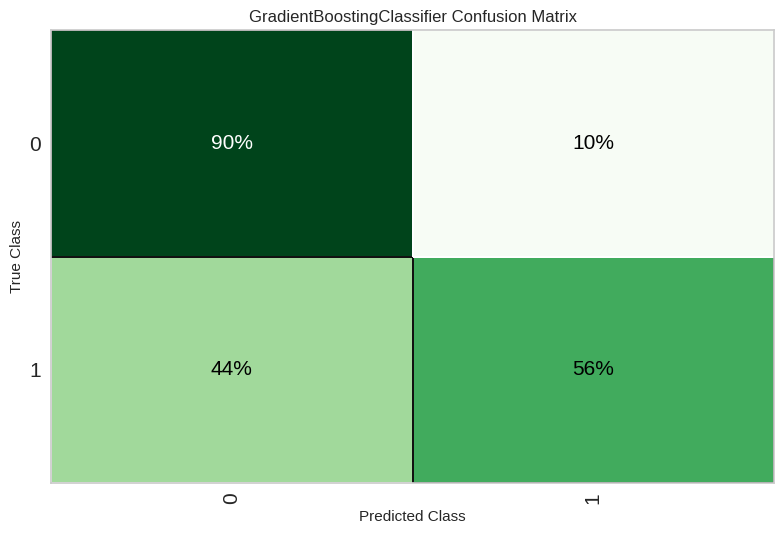

In [45]:
exp.plot_model(model, plot='confusion_matrix', plot_kwargs={'percent':True})

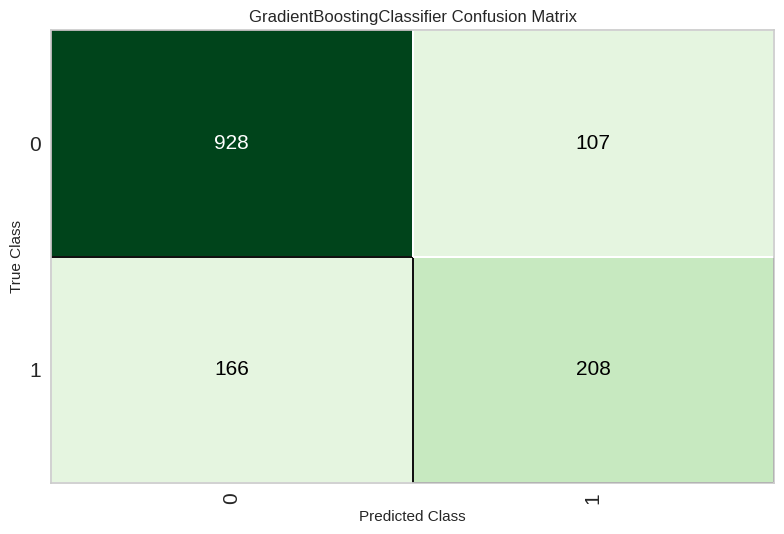

In [46]:
exp.plot_model(model, plot='confusion_matrix')

##### b) AUROC

![](figures/16_2.png)
![](figures/16_4.png)

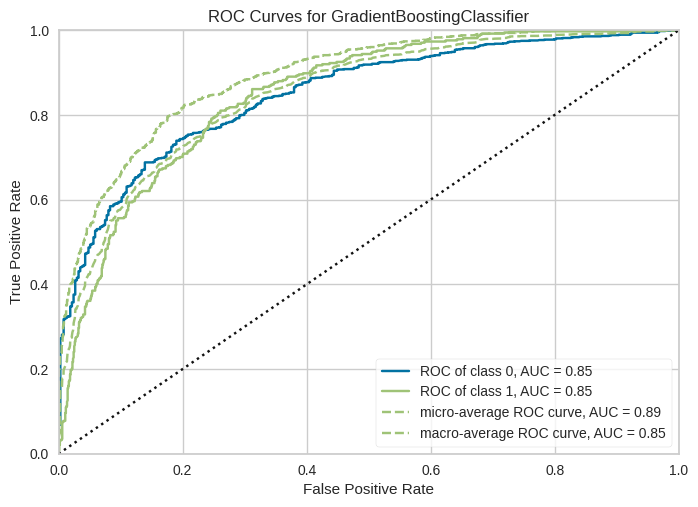

In [47]:
exp.plot_model(model, plot='auc')

#### 2) 모델 해석

##### a) 모델 Threshold

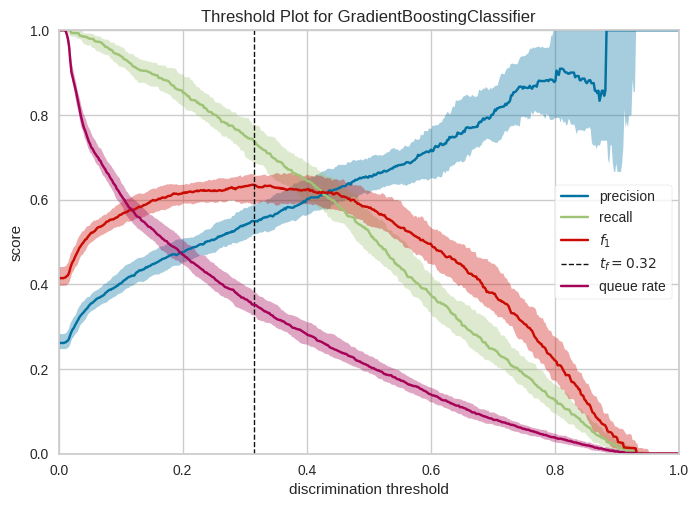

In [48]:
exp.plot_model(model, plot='threshold')

##### b) 모델 Training history

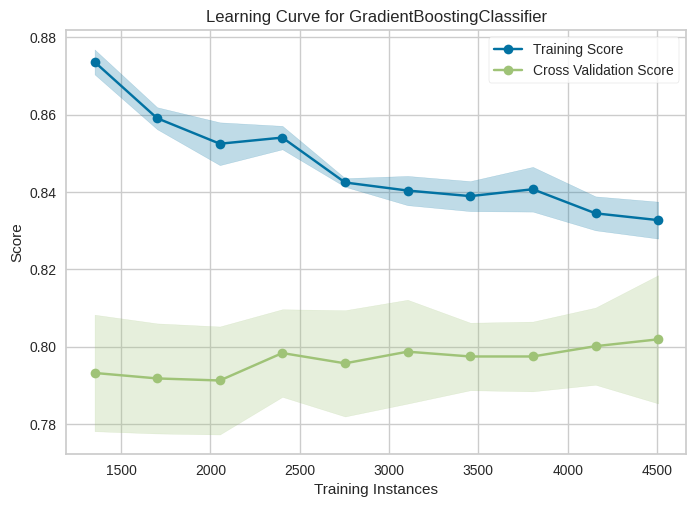

In [49]:
exp.plot_model(model, plot='learning')

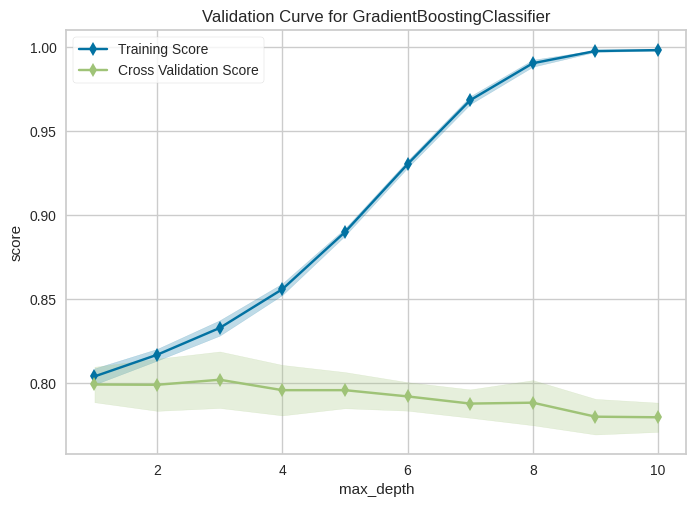

In [50]:
exp.plot_model(model, plot='vc')

##### c) 모델 Decision boundary 시각화
![](figures/16_6.png)

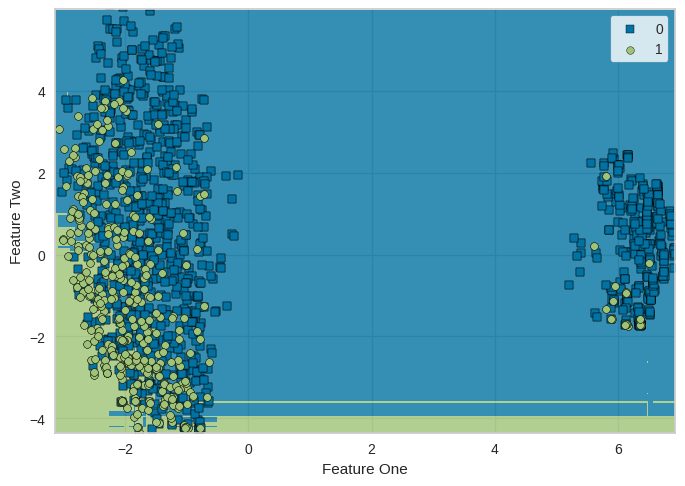

In [51]:
exp.plot_model(model, plot='boundary')

### · 중요 변수 파악
---
* Feature importance 분석을 통한 중요변수 파악


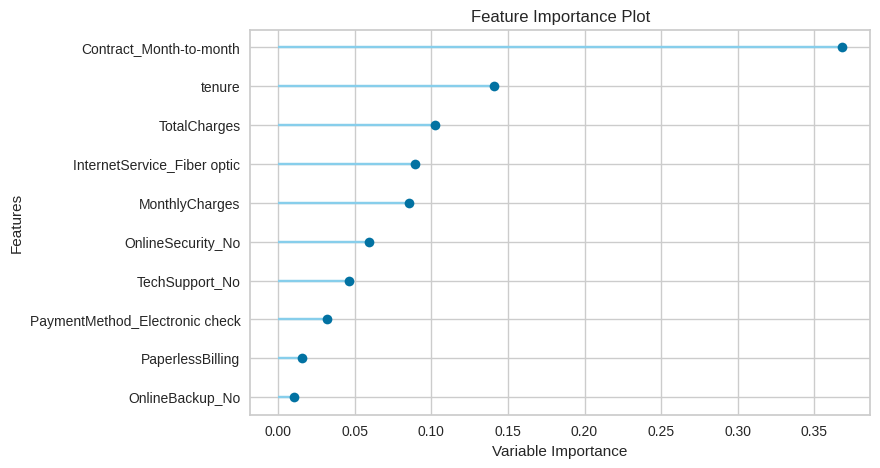

In [52]:
exp.plot_model(model, plot='feature')

- RFE (Recursive feature elimiation)


### · 모델 확인
---
* 실험으로부터 사용할 수 있는 모델을 불러오기

In [54]:
model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=3589, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [55]:
model_finalized = exp.finalize_model(model)

In [56]:
x_test = exp.X_test
x_test

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
4342-HFXWS,Female,Yes,Yes,Yes,No,DSL,Yes,No,Yes,Yes,Yes,No,One year,No,Bank transfer (automatic),0,48,69.699997,3023.649902
9185-TQCVP,Male,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,0,14,85.150002,1139.199951
3717-OEAUQ,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Mailed check,0,2,70.699997,129.199997
8313-KTIHG,Male,No,No,Yes,No,DSL,No,No,No,Yes,Yes,No,Month-to-month,Yes,Electronic check,0,4,61.299999,249.399994
0784-ZQJZX,Male,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0,72,19.900000,1529.650024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0739-UUAJR,Female,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),0,72,53.799999,3952.449951
8514-VZHEB,Male,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0,59,19.500000,1147.849976
5084-OOVCJ,Female,Yes,Yes,Yes,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),0,17,55.349998,920.500000


In [57]:
y_test = exp.y_test
y_test

,Churn
customerID,
4342-HFXWS,No
9185-TQCVP,Yes
3717-OEAUQ,No
8313-KTIHG,No
0784-ZQJZX,No
...,...
0739-UUAJR,No
8514-VZHEB,No
5084-OOVCJ,No


In [58]:
from sklearn.metrics import roc_auc_score

yhat_test = model_finalized.predict(x_test)
roc_auc_score(
    yhat_test.apply(lambda x : 1 if x=='Yes' else 0),
    y_test.apply(lambda x : 1 if x=='Yes' else 0),
)

0.8004886135590262


### · 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [67]:
exp.save_model(
    model=model_finalized,
    model_name='/tmp/model_{experiment_name}_v1'
)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['SeniorCitizen', 'tenure',
                                              'MonthlyCharges', 'TotalCharges'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='log_loss',
                                             max

In [69]:
# 모델 저장 경로와 이름을 맞춰서 로드
model_loaded = exp.load_model(
    model_name='/tmp/model_{experiment_name}_v1'
)

Transformation Pipeline and Model Successfully Loaded


In [70]:
model_loaded.predict(x_test)

,Churn
0,No
1,Yes
2,No
3,No
4,No
...,...
1404,No
1405,No
1406,No
1407,Yes
